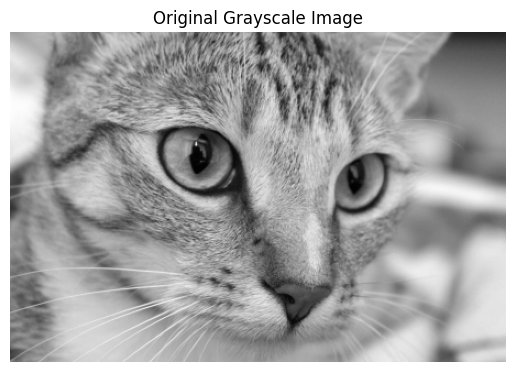

** Layer 1 **


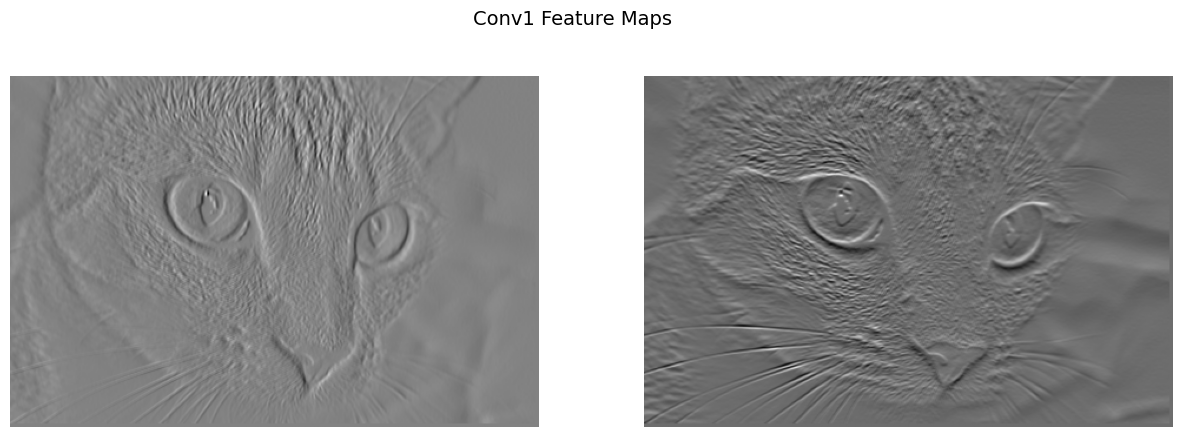

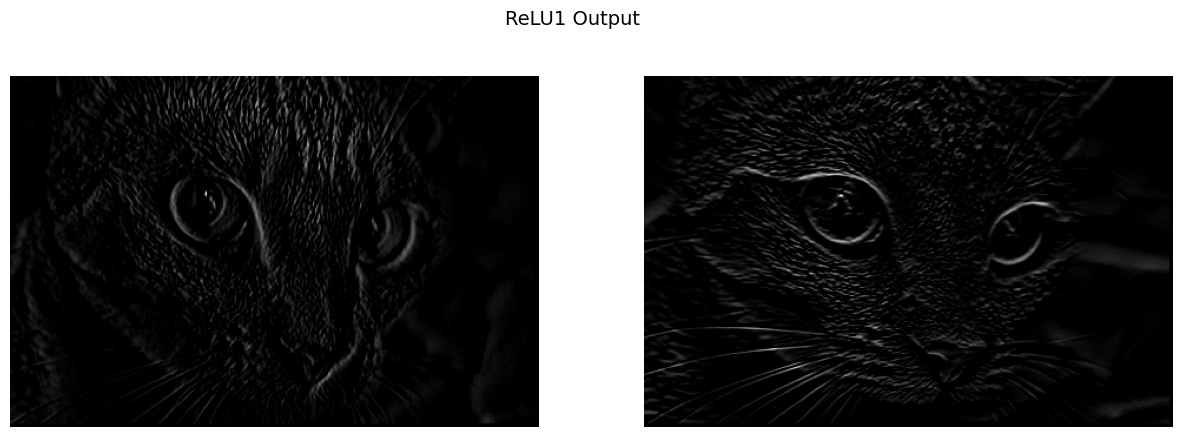

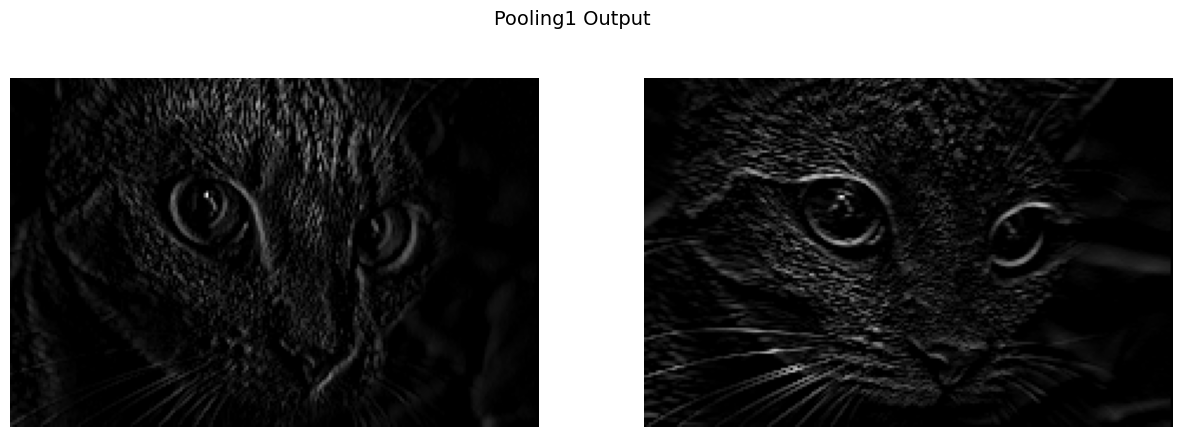

** Layer 2 **


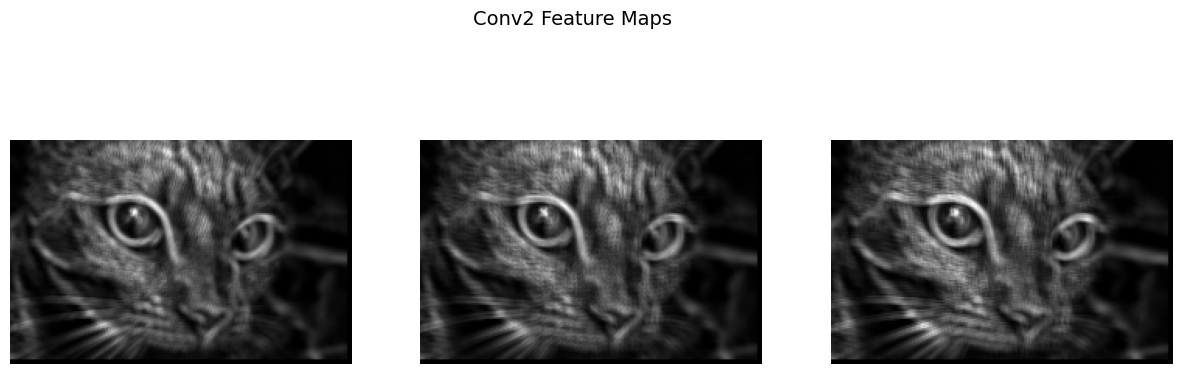

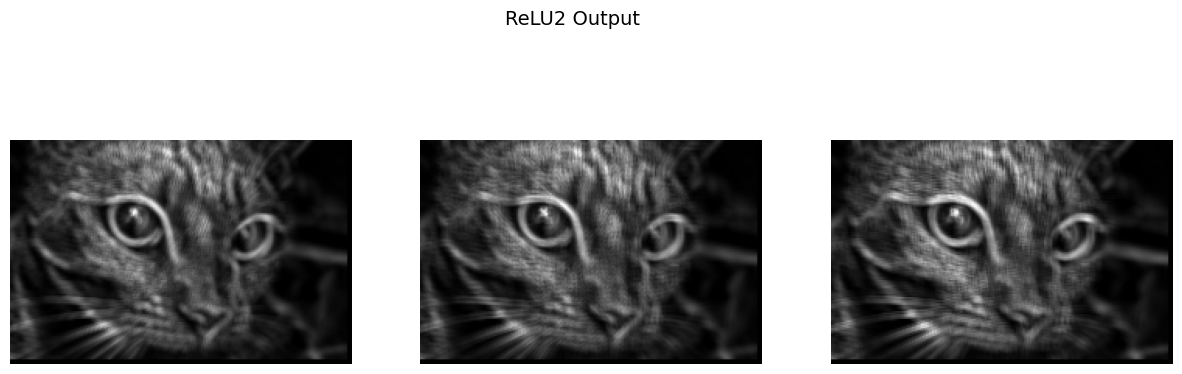

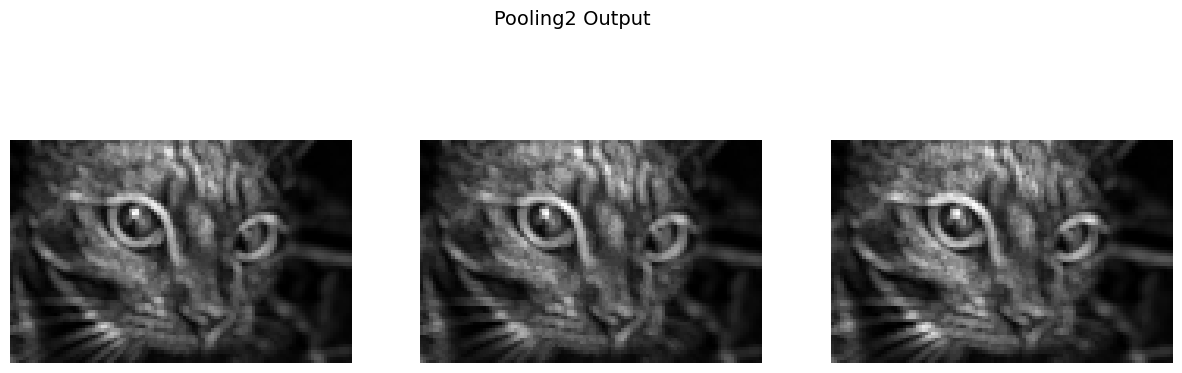

** Layer 3 **


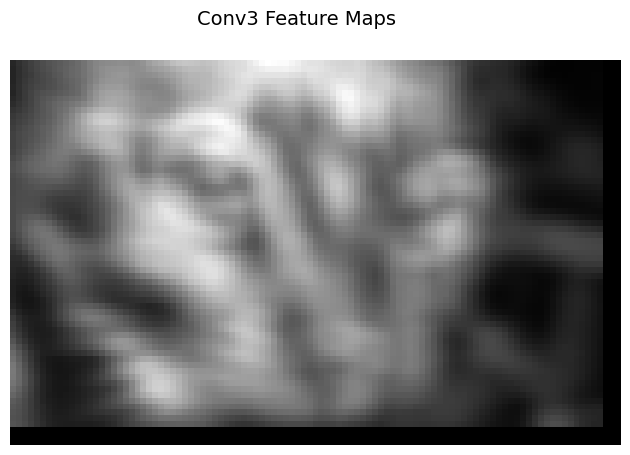

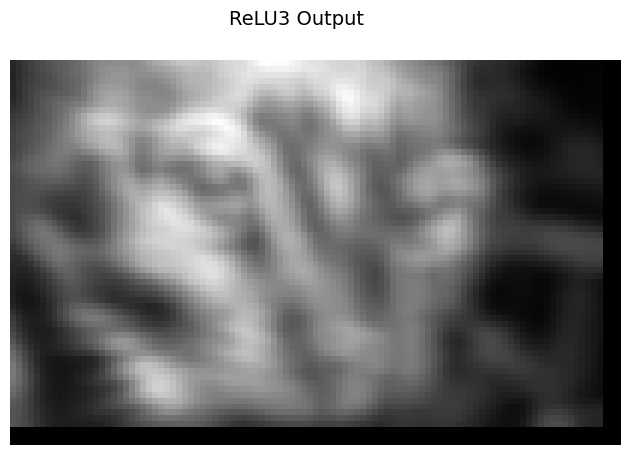

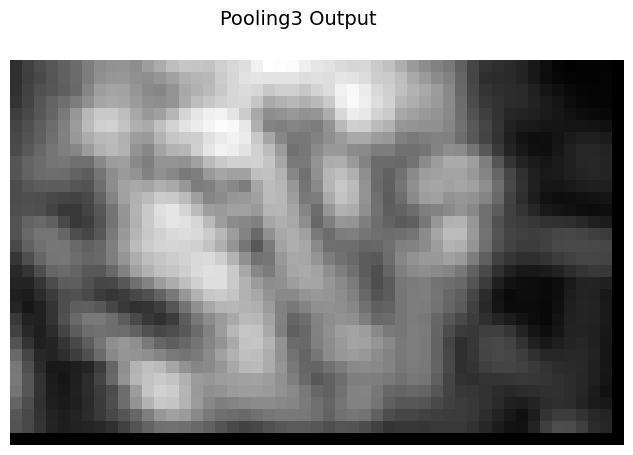

** End of CNN Pipeline **
Saved: conv1.png


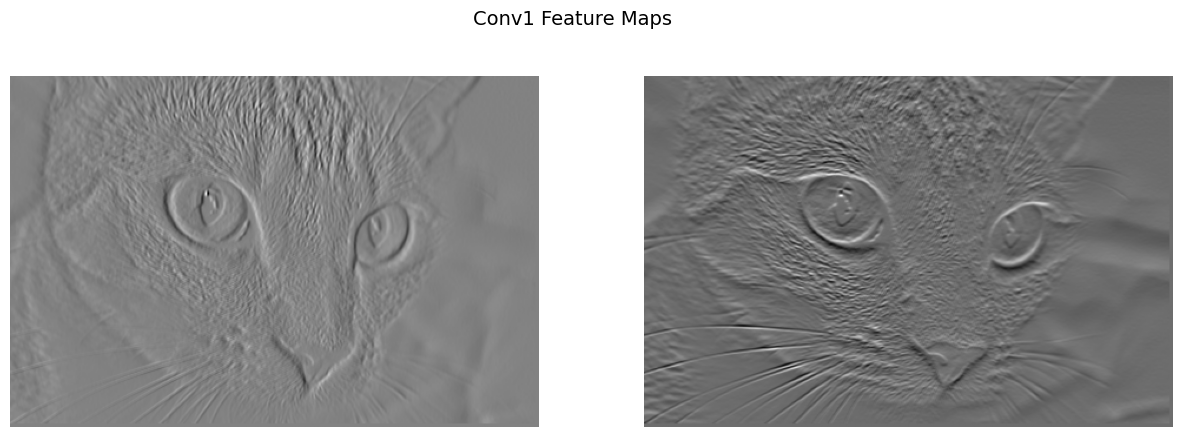

Saved: relu1.png


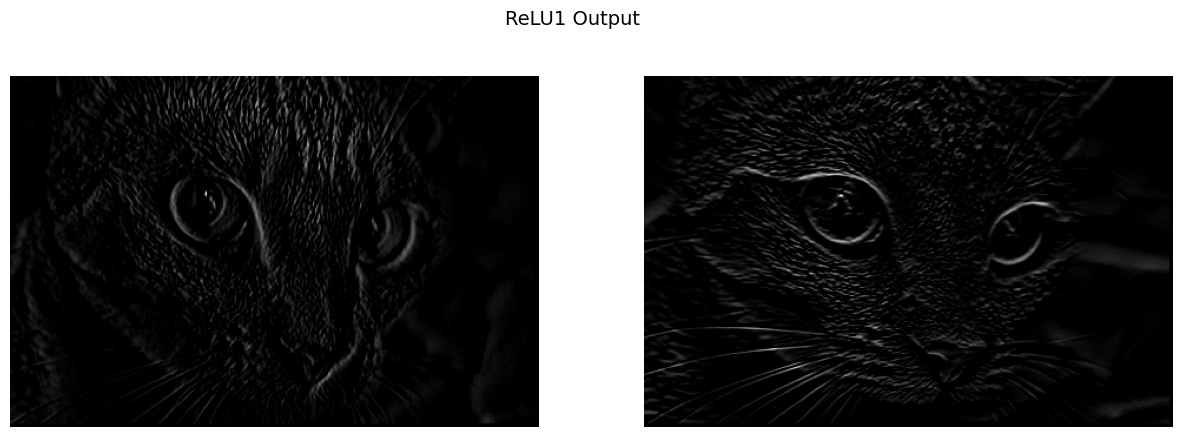

Saved: pool1.png


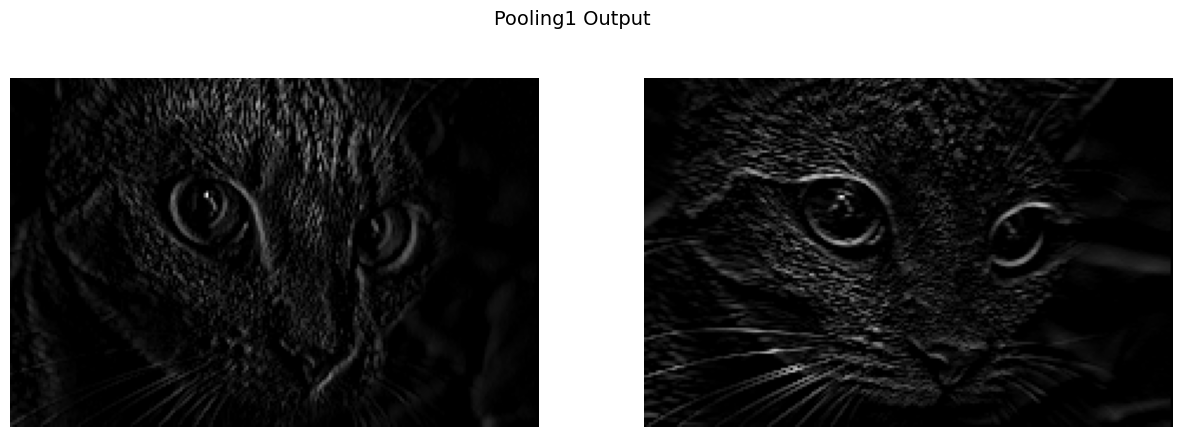

In [8]:

"""
===============================================================
Manual CNN Implementation (Convolution → ReLU → Pooling)
===============================================================
This script demonstrates a step-by-step convolutional neural 
network (CNN) pipeline applied to an image. We implement all 
operations manually: convolution, ReLU activation, and pooling.

Algorithm Description:
----------------------
1. Input Image
   - Load a test image and convert it to grayscale.

2. Convolution Layer
   - Apply filters (kernels) to the image.
   - Each filter slides over the image and computes a weighted 
     sum → produces a feature map.
   - Filters are designed to detect edges, patterns, textures.

3. ReLU Activation
   - Apply non-linearity: ReLU(x) = max(0, x).
   - This keeps only positive activations and removes negative 
     values.
   - It introduces non-linearity into the model.

4. Pooling Layer
   - Apply max pooling with size 2×2 and stride 2.
   - This downsamples the feature map by taking the maximum value 
     from each block.
   - Reduces spatial dimensions and computation, while keeping 
     important features.

5. Repeat Layers
   - We stack 3 convolutional layers, each followed by ReLU and 
     pooling.
   - Layer 1: Predefined edge filters (horizontal & vertical).
   - Layer 2: Random filters to learn more abstract features.
   - Layer 3: Larger random filter to capture high-level features.

6. Feature Maps Visualization
   - After each Conv → ReLU → Pool step, we plot the resulting 
     feature maps.
   - These maps show how the image is transformed layer by layer 
     into abstract features.

End Goal:
---------
This process extracts hierarchical features from the image. 
In a real CNN, these final feature maps would be flattened and 
passed to fully connected layers for classification.
"""  


import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import skimage.color

# -----------------------------
# Convolution helper
# -----------------------------
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[0]
    result = np.zeros((img.shape))
    # Loop over the image
    for r in np.uint16(np.arange(filter_size/2, img.shape[0]-filter_size/2-2)):
        for c in np.uint16(np.arange(filter_size/2, img.shape[1]-filter_size/2-2)):
            curr_region = img[r:r+filter_size, c:c+filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)
            result[r, c] = conv_sum
    # Clip borders
    final_result = result[np.uint16(filter_size/2):result.shape[0]-np.uint16(filter_size/2),
                          np.uint16(filter_size/2):result.shape[1]-np.uint16(filter_size/2)]
    return final_result

def conv(img, conv_filter):
    # feature maps (h, w, num_filters)
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,
                             img.shape[1]-conv_filter.shape[1]+1,
                             conv_filter.shape[0]))
    # Apply each filter
    for filter_num in range(conv_filter.shape[0]):
        curr_filter = conv_filter[filter_num, :]
        if len(curr_filter.shape) > 2:  # multiple channels
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map += conv_(img[:, :, ch_num], curr_filter[:, :, ch_num])
        else:  # single channel
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map
    return feature_maps

# -----------------------------
# ReLU
# -----------------------------
def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0, feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

# -----------------------------
# Pooling
# -----------------------------
def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride),
                         np.uint16((feature_map.shape[1]-size+1)/stride),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0, feature_map.shape[0]-size, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size, stride):
                pool_out[r2, c2, map_num] = np.max(feature_map[r:r+size, c:c+size, map_num])
                c2 += 1
            r2 += 1
    return pool_out

# -----------------------------
# Plotting
# -----------------------------
def plot_feature_maps(feature_map, title):
    num_maps = feature_map.shape[-1]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    fig.suptitle(title, fontsize=14)

    # If only 1 map, axes is not a list
    if num_maps == 1:
        axes.imshow(feature_map[:, :, 0], cmap="gray")
        axes.axis("off")
    else:
        for i in range(num_maps):
            axes[i].imshow(feature_map[:, :, i], cmap="gray")
            axes[i].axis("off")
    plt.show()


# -----------------------------
# MAIN PIPELINE
# -----------------------------
img = skimage.data.chelsea()
img = skimage.color.rgb2gray(img)

plt.imshow(img, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")
plt.show()

# ---- Layer 1 ----
l1_filter = np.zeros((2, 3, 3))
l1_filter[0, :, :] = np.array([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])
l1_filter[1, :, :] = np.array([[1, 1, 1],
                               [0, 0, 0],
                               [-1, -1, -1]])

print("** Layer 1 **")
l1_feature_map = conv(img, l1_filter)
plot_feature_maps(l1_feature_map, "Conv1 Feature Maps")

l1_relu = relu(l1_feature_map)
plot_feature_maps(l1_relu, "ReLU1 Output")

l1_pool = pooling(l1_relu, 2, 2)
plot_feature_maps(l1_pool, "Pooling1 Output")

# ---- Layer 2 ----
print("** Layer 2 **")
l2_filter = np.random.rand(3, 5, 5, l1_pool.shape[-1])
l2_feature_map = conv(l1_pool, l2_filter)
plot_feature_maps(l2_feature_map, "Conv2 Feature Maps")

l2_relu = relu(l2_feature_map)
plot_feature_maps(l2_relu, "ReLU2 Output")

l2_pool = pooling(l2_relu, 2, 2)
plot_feature_maps(l2_pool, "Pooling2 Output")

# ---- Layer 3 ----
print("** Layer 3 **")
l3_filter = np.random.rand(1, 7, 7, l2_pool.shape[-1])
l3_feature_map = conv(l2_pool, l3_filter)
plot_feature_maps(l3_feature_map, "Conv3 Feature Maps")

l3_relu = relu(l3_feature_map)
plot_feature_maps(l3_relu, "ReLU3 Output")

l3_pool = pooling(l3_relu, 2, 2)
plot_feature_maps(l3_pool, "Pooling3 Output")

print("** End of CNN Pipeline **")



def plot_feature_maps(feature_map, title, filename=None):
    num_maps = feature_map.shape[-1]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    fig.suptitle(title, fontsize=14)
    
    if num_maps == 1:
        axes.imshow(feature_map[:, :, 0], cmap="gray")
        axes.axis("off")
    else:
        for i in range(num_maps):
            axes[i].imshow(feature_map[:, :, i], cmap="gray")
            axes[i].axis("off")
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")  # save result
        print(f"Saved: {filename}")
    plt.show()


plot_feature_maps(l1_feature_map, "Conv1 Feature Maps", "conv1.png")
plot_feature_maps(l1_relu, "ReLU1 Output", "relu1.png")
plot_feature_maps(l1_pool, "Pooling1 Output", "pool1.png")
